# Advanced Methods in Natural Language Processing - Final Project
## Predicting Movie Genres from Movie Descriptions
### Nikita Baklazhenko, Miguel Conner, David Vallmanya, Dominik Wielath

For our final project, we analyzed a data set of movie descriptions from the Internet Movie Database (IMDb) posted on Kaggle. The data set contains, besides the movie description also, its title, the year it was published, and its genre. Our project aims to predict the genre of a movie based on its description. In particular, we compare different methods regarding their predictive power, strengths, and limitations. 



In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import re 

from collections import Counter

# Natural language Toolkit
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics import f1_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from helper_functions import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [2]:
# Set directory
directory_david = '/run/media/david-vp/davidvp-files/DSMMaster/advanced-nlp/final-proj/Genre Classification Dataset/'
directory_david2 = '/run/media/davovapo/hdd1-dvp/DSMMaster/advanced-nlp/Advanced_NLP_Project/Genre Classification Dataset/'
directory_miguel ='/Users/Miguel/Desktop/BSE/Term2/Advanced NLP/Advanced_NLP_Project/Genre Classification Dataset/'
directory_dominik = ''

directory = directory_dominik

In [3]:
# Load training data set
filename ="train_data.txt"

df_train = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)

df_train.drop(columns=df_train.columns[0], axis=1, inplace=True)
df_train.columns =['title', 'genre', 'description']
df_train['genre']=df_train['genre'].apply(lambda x: x.strip())

df_train.head()

<ipython-input-3-2833bd79dfe9>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_train = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)


,title,genre,description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
# Load testing data set
filename = "test_data_solution.txt"
df_test = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)

df_test.drop(columns=df_test.columns[0], axis=1, inplace=True)
df_test.columns =['title', 'genre', 'description']
df_test['genre']=df_test['genre'].apply(lambda x: x.strip())

df_test.head()

<ipython-input-4-16282b81ed68>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_test = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)


,title,genre,description
0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),drama,Before he was known internationally as a mart...


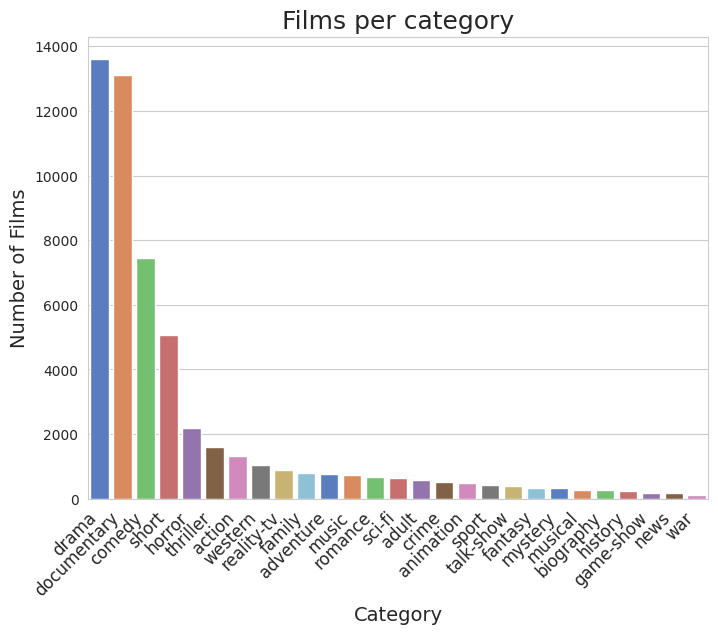

In [5]:
# Create a bar plot of the genre counts
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.barplot(x=df_train.genre.value_counts().index,
            y=df_train.genre.value_counts(),
            palette="muted")

# Customize the plot
plt.title("Films per category", fontsize=18)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Films", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Show the plot
plt.show()

We can see that we have very large class imbalance. There are many movies in few categories while most categories only contain a small number of movies. As we expect our model's performance to correlate with the sample size for each category, we exclude categories with very few numbers of movies within our training set. Further, we exclude genres from which we expect that there might be larger variation in the topics discussed in the description. For example a short film could deal with topics similar to genres like horror or comedy. There is likely no clear pattern. Therefore, we also exclude these categories in our analysis. 

In [6]:
# Only keep some columns
list_labels = ["drama", "comedy", "horror", "thriller", "action", "western", "sci-fi"]

df_train = df_train[df_train["genre"].isin(list_labels)]
df_test = df_test[df_test["genre"].isin(list_labels)]

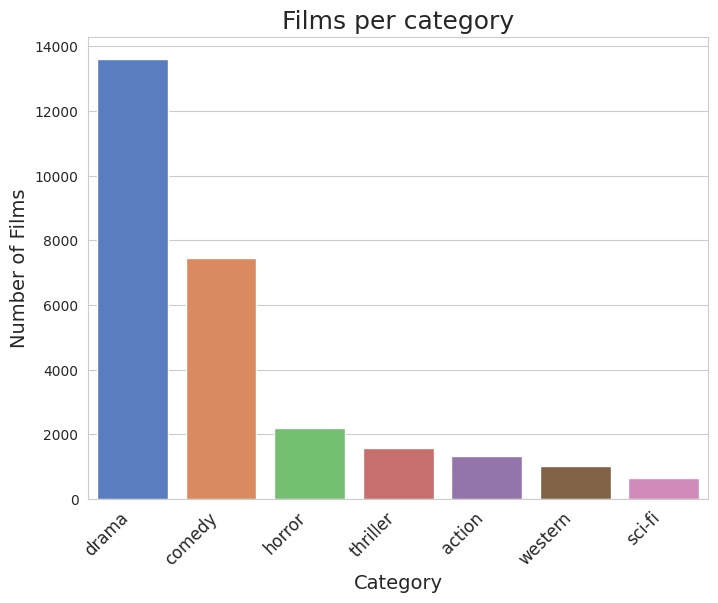

In [7]:
# Create a bar plot of the genre counts
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.barplot(x=df_train.genre.value_counts().index,
            y=df_train.genre.value_counts(),
            palette="muted")

# Customize the plot
plt.title("Films per category", fontsize=18)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Films", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Show the plot
plt.show()

# Preprocessing

## Extract the year from the title and save it as variable in the data frame

In [8]:
df_train["year"] = df_train["title"].apply(get_year)
df_test["year"] = df_test["title"].apply(get_year)

## Remove Stopwords

In [10]:
# Defining stopwords
# using predefined english stopwords
stop_words = set(stopwords.words('english'))

# including additional stopwords
my_stopwords = ['lol', 'people', 'expand',
                'really', 'deal','u', 'much', 'get', 'good', 'act', 'put', 'man', 'a', 'think', 'one',
                'say', 'like', 'go', 'do', 'head', 'yet', 'wall', 'guess', 'keep', 'oh', 'north', 'oil',
                'prize', 'involved', 'might', 'medium''among', 'might', 'make', 'do', 'may', 'year', 'give',
                'also', 'law', 'etc', 'wait', 'prove', 'mean', 'thing', 'rest', 'middle','rnr','u','fuck','make',
                'would', 'know', 'lot', 'see', 'president', 'done', 'even', 'many', 'ever', 'want', 'made',
                'got', 'going', 'need', 'view', 'something', 'lasting', 'still', 'way', 'every', 'anyone', 
                'first', 'look', 'medium', 'time', 'since', 'life', 'probably', 'anything', 'come', 
                'long', 'could', 'anything', 'donald', 'back', 'sure', 'last', 'nothing', 'rate', 'well',
                'left', 'le', 'someone', 'example', 'seen', 'day', 'said', 'world', 'making', 'far', 'care',
                'shit','america','issue','new', 'actually','never','whole','exposed','imapct','side','single']
stop_words.update(my_stopwords)

In [11]:
df_train['description_pp'] = df_train['description'].apply(remove_stopwords, args=(stop_words,))
df_test['description_pp'] = df_test['description'].apply(remove_stopwords, args=(stop_words,))

### Lemmatize

In [12]:
# Tokenize: Split the sentence into words
docs = df_train['description_pp']

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# Lemmatize list of words and join
lemmatized_output = [''.join([lemmatizer.lemmatize(w) for w in doc]) for doc in docs]
df_train['description_pp'] = lemmatized_output
df_train.head()

,title,genre,description,year,description_pp
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,2009,"Listening conversation doctor parents, 10-year..."
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,1997,brother sister past incestuous relationship cu...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1915,"help unemployed father ends meet, Edith twin s..."
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,2007,film's title refers un-recovered bodies ground...
6,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...,2009,"tough economic times Max Joey run ideas until,..."


In [13]:
# Tokenize: Split the sentence into words
docs = df_test['description_pp']

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# Lemmatize list of words and join
lemmatized_output = [''.join([lemmatizer.lemmatize(w) for w in doc]) for doc in docs]
df_test['description_pp'] = lemmatized_output
df_test.head()

,title,genre,description,year,description_pp
0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",1998,"L.R. Brane loves - car, apartment, job, especi..."
1,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",1977,"Spain, March 1964: Quico naughty child three b..."
3,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",2015,"father died, spoken brother 10 years serious c..."
4,Er nu zhai (1955),drama,Before he was known internationally as a mart...,1955,"known internationally martial arts superstar, ..."
5,Riddle Room (2016),horror,Emily Burns is being held captive in a room w...,2016,Emily Burns held captive room idea there. Dete...


# Baseline

## Random assignment based on frequency of genres in the training data

Choose randomly among the genres and use the share of the genres in the training data set as probability that a specific genre is assigned

In [14]:
genre_priors = df_train.genre.value_counts() / df_train.shape[0]
genre_priors = pd.DataFrame(data={"genre":genre_priors.index, "probability": genre_priors.values})
genre_priors = genre_priors.sort_values("genre")

In [15]:
# Predict genres for test data
prior_predictions = np.random.choice(genre_priors.genre.values, size = df_test.shape[0], p = genre_priors.probability.values)
df_test["prior_predictions"] = prior_predictions

In [16]:
# Evaluate prediction performance
true_labels = df_test["genre"]
f1 = f1_score(true_labels, prior_predictions, average="weighted")
recall = recall_score(true_labels, prior_predictions, average="weighted")

print("F1: ",f1)
print("Recall: ",recall)

F1:  0.32580814337081754
Recall:  0.3266772015515012


## Dictionary based prediction

### Frequency (TF) dictionary

Creating an dictionary using the 50 most frequent words per category.

In [17]:
terms_by_genre = {}

# Iterrate over genres
for genre in df_train['genre'].unique():

    # Join descriptions of all movies for each genre
    genre_df = df_train[df_train['genre'] == genre]
    all_descriptions = ' '.join(genre_df['description_pp'])
    all_words = all_descriptions.split()
    word_counts = Counter(all_words)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    top_words = [word for word, count in sorted_words[:50]]
    terms_by_genre[genre] = top_words

In [18]:
df_test["frequency_prediction"] = dictionary_predictions(df_test, "description_pp", terms_by_genre, genre_priors)

Share of data which was labeled based on dictionary: 0.521
Share of data randomly labled using prior distribution: 0.479


In [19]:
true_labels = df_test["genre"]
f1 = f1_score(true_labels, df_test["frequency_prediction"], average="weighted")
recall = recall_score(true_labels, df_test["frequency_prediction"], average="weighted")

print("F1: ",f1)

print("Recall: ",recall)

F1:  0.4091824381667852
Recall:  0.3920772877460135


### TF-IDF dictionary

In [20]:
# Create a dictionary with the most important words per genre 
genre_descriptions = df_train.groupby(['genre'])['description_pp'].apply(','.join).reset_index()
important_dict_tfidf = create_tfidf_dict(genre_descriptions, 'description_pp', 'genre', 50)

In [21]:
df_test["tfidf_prediction"] = dictionary_predictions(df_test, "description_pp", important_dict_tfidf, genre_priors)

Share of data which was labeled based on dictionary: 0.303
Share of data randomly labled using prior distribution: 0.697


In [22]:
# Evaluate prediction performance
true_labels = df_test["genre"]
f1 = f1_score(true_labels, df_test["tfidf_prediction"], average="weighted")
recall = recall_score(true_labels, df_test["tfidf_prediction"], average="weighted")

print("F1: ",f1)
print("Recall: ",recall)

F1:  0.4063986940496601
Recall:  0.39940382129004454


# GRU Network

In this report we choose a Gated Recurrent Unit (GRU) neural network for our Recurrent Neural Network (RNN) model. GRU neural networks are designed to capture long-term dependencies in sequential data, they use two gate mechanisms to control the flow of information between the hidden states of the network.

On one hand, there's the update gate which helps the model to determine how much of the past information (from previous time steps) needs to be passed along to the future. Finally there's also the reset gate which is used from the model to decide how much of the past information to forget. This allows them to selectively update or forget information from previous time steps, which helps prevent the vanishing gradient problem and allows them to better handle long-term dependencies.

Additionally, we chose a GRU model because they are computationally efficient and have fewer parameters compared to other RNNs like Long Short-Term Memory (LSTM), making them a good choice when we have with limited computational resources.

In [ ]:
# input and target columns
X_train = df_train["description"].values
y_train = pd.get_dummies(df_train["genre"]).values

X_test = df_test["description"].values
y_test = pd.get_dummies(df_test["genre"]).values

# find the maximum length of the descriptions or 1200
maxlen = min(max(len(description) for description in X_train), 1200)

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
# tokenize the input text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

In our case we will build a one layer GRU neural network, with a final softmax layer to choose over the 7 possible final classes.

In [ ]:
if os.path.isfile('bidir_gru_model'):
    
    model = keras.models.load_model('bidir_gru_model')
    
else:
        
    # define the model architecture
    model = Sequential()
    model.add(Embedding(10000, 64, input_length=maxlen))
    model.add(Bidirectional(GRU(64, dropout=0.12)))
    model.add(Dense(7, activation="softmax"))

    # compile the model
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    
    # train the model
    model.fit(X_train, y_train, epochs=16,batch_size=32, validation_split=0.2)
    
    model.save('bidir_gru_model')

Epoch 1/20
697/697 [==============================] - 189s 268ms/step - loss: 1.1763 - accuracy: 0.5636 - val_loss: 0.9443 - val_accuracy: 0.6591
Epoch 2/20
697/697 [==============================] - 188s 269ms/step - loss: 0.8163 - accuracy: 0.7056 - val_loss: 0.8963 - val_accuracy: 0.6858
Epoch 3/20
697/697 [==============================] - 185s 265ms/step - loss: 0.6168 - accuracy: 0.7832 - val_loss: 0.8992 - val_accuracy: 0.6968
Epoch 4/20
697/697 [==============================] - 189s 271ms/step - loss: 0.4577 - accuracy: 0.8370 - val_loss: 1.0352 - val_accuracy: 0.6632
Epoch 5/20
697/697 [==============================] - 202s 290ms/step - loss: 0.3260 - accuracy: 0.8900 - val_loss: 1.1670 - val_accuracy: 0.6598
Epoch 6/20
288/697 [===========>..................] - ETA: 1:44 - loss: 0.1988 - accuracy: 0.9386

In [ ]:
# evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)
f1 = f1_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
print("F1 score:", f1)
print("Recall score:", recall)